## 구조화된 데이터(CSV)를 분류하는 방법을 학습하는 튜토리얼


course notebook 주소: 

https://github.com/GoogleCloudPlatform/training-data-analyst


training-data-analyst > courses > machine_learning > deepdive2 > introduction_to_tensorflow > labs, and open preprocessing_layers.ipynb.

## 학습 목표

- Pandas를 사용해 CSV 파일 로드
- tf.data를 사용해 배치 처리 및 셔플링 파이프라인 구축
- Keras Preprocessing Layers를 사용해 CSV 컬럼을 모델 특성으로 매핑
- Keras를 사용해 모델 구축, 훈련, 평가

## 데이터셋: PetFinder
- 반려동물 입양 예측 데이터셋
- 각 행은 한 마리의 반려동물을 나타냄
- 목표: 반려동물이 입양될지 예측 (이진 분류)


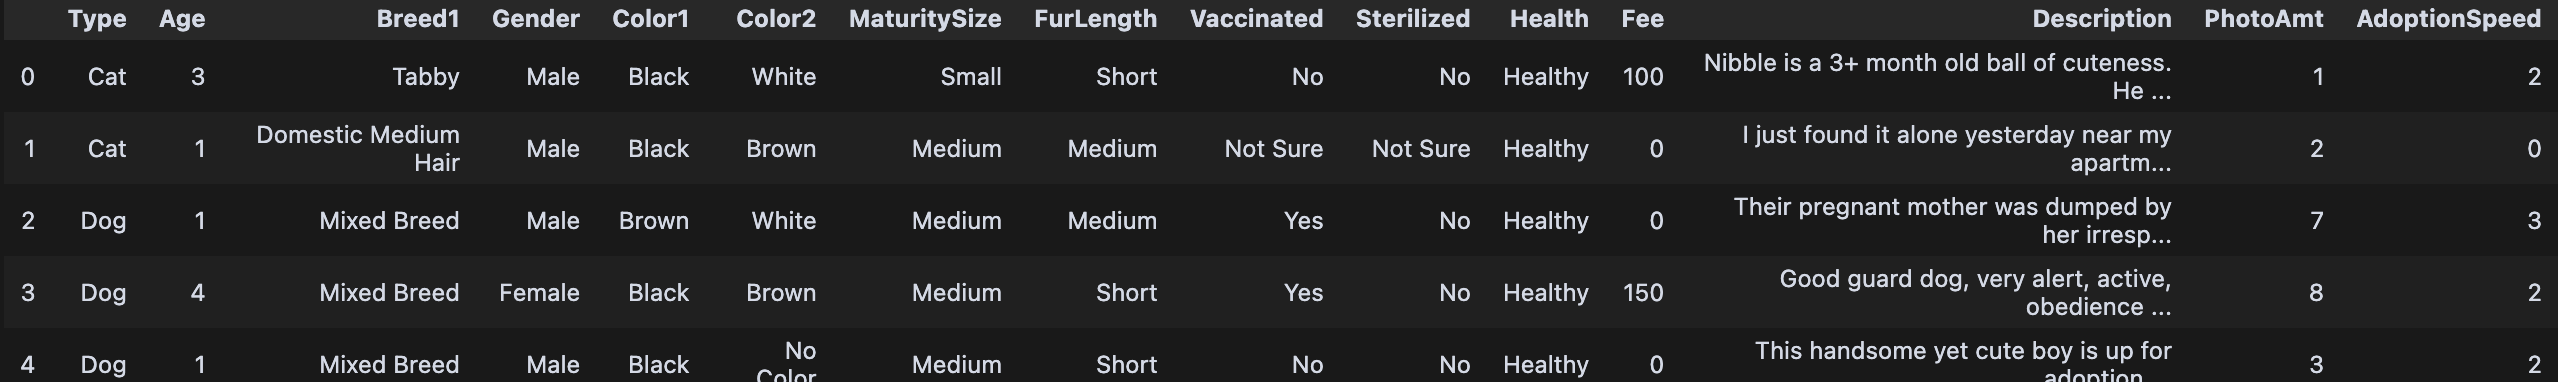


### 사용하는 라이브러리

```python
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
```

### 타겟 변수 생성, 데이터 분할
```python
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)
```
`np.where(condition, x, y)`: 조건에 따라 다른 값 반환
- `AdoptionSpeed` == 4 -> target = 0 : 입양 안됨
- `AdoptionSpeed` != 4 -> target = 1 : 입양

```python
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])
```
`dataframe.drop(columns=[...])`: 불필요한 컬럼 제거
- `AdoptionSpeed` : target으로 변환되어 제거
- `Description`: 텍스트 데이터, 여기서는 사용 안함

원래 문제: AdoptionSpeed -> 0 ~ 4 : 입양 속도 분류가 여러개로 나뉘었다.

단순화된 문제: target -> 0 | 1 : 입양 여부 예측 -> 이진 문제

복잡한 문제를 이진 분류로 단순화

```python
# 조건에 따라 여러 값
result = np.where(condition1, 0, 
                 np.where(condition2, 1, 2))
```

### 데이터 분할 - train, validation, and test

```python
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
```

- 훈련 세트: 64% (전체의 80% × 80%) - 모델 학습에 사용
- 검증 세트: 16% (전체의 80% × 20%) - 하이퍼파라미터 튜닝, 조기 종료 등에 사용
- 테스트 세트: 20% - 최종 성능 평가 (한 번만 사용)



### tf.data 파이프라인 구축

```python
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
```
- tf.data.Dataset.from_tensor_slices(): DataFrame을 TensorFlow Dataset으로 변환
- ds.shuffle(): 데이터 셔플링 (훈련 시에만)
- ds.batch(): 배치 단위로 처리
- ds.prefetch(): 성능 최적화 (다음 배치 미리 로드)




```python
batch_size = 5
train_ds = df_to_dataset(train)
```

```python
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )
```

- train_ds.take(1): 데이터셋에서 1개 배치 가져오기
- train_features: 특성들의 딕셔너리
- label_batch: 타겟 값들


```
Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor(
[ 4  1 10 60 24 12 22  6 36 72  3  2  3  6 60  4 12  4  1  2 15 12  1  3
  3  5  2  2  2  3  2  2], shape=(32,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1], shape=(32,), dtype=int64)
```


## 전처리 레이어

*   [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) - 수치형 데이터 정규화 (평균=0, 표준편차=1)
*   [`CategoryEncoding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/CategoryEncoding) - 범주형 데이터 인코딩 (원-핫 인코딩 등)
*   [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup) - 문자열을 정수 인덱스로 변환
*   [`IntegerLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/IntegerLookup) - 정수를 정수 인덱스로 변환

### 정규화 레이어 함수
```python
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

# TODO
# Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer
```

- preprocessing.Normalization(axis=None): 특성별 정규화 레이어 생성
- feature_ds: 특정 특성만 추출하는 데이터셋
- normalizer.adapt(feature_ds): 데이터의 통계 정보 학습 (평균, 표준편차)
- return normalizer: 학습된 정규화 레이어 반환

```python
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)
```

- train_features['PhotoAmt']: PhotoAmt 특성 추출
- get_normalization_layer('PhotoAmt', train_ds): PhotoAmt용 정규화 레이어 생성
- layer(photo_count_col): 정규화 적용


## 범주형 컬럼 처리

범주형 인코딩 레이어 함수
```python
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

# TODO
  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y : x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

```

- StringLookup vs IntegerLookup:
    - StringLookup: 문자열 → 정수 인덱스
    - IntegerLookup: 정수 → 정수 인덱스
- index.adapt(feature_ds): 가능한 값들을 학습하고 고유 인덱스 할당
- CategoryEncoding: 정수 인덱스를 원-핫 벡터로 변환
- return lambda feature: encoder(index(feature)):
    - 입력 → 인덱스 변환 → 원-핫 인코딩
    - 함수를 반환하여 나중에 사용

## 사용할 특성 선택

- Keras Functional API 사용: Sequential보다 유연함
- 임의로 선택된 특성들: 튜토리얼 목적으로 일부만 사용
- 실제 모델링: 더 많은 특성과 신중한 선택 필요


```python
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
```
성능향상을 위한 배치 크기 조정
- shuffle = False : 검증, 테스트 세트는 셔플링 하지 않음 -> 일관된 평가를 위해

```python
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
```

1. tf.keras.Input(shape=(1,), name=header):
- 모델의 입력 레이어 생성
- shape=(1,): 1차원 입력
- name=header: 특성 이름 지정
2. get_normalization_layer(header, train_ds): 정규화 레이어 생성
3. normalization_layer(numeric_col): 정규화 적용
4. 리스트에 추가:
- all_inputs: 모든 입력 레이어들
- encoded_features: 전처리된 특성들

### 나이 특성 처리 - 범주형으로

```python
# Categorical features encoded as integers.
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')
encoding_layer = get_category_encoding_layer('Age', train_ds, dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)
```

- 나이를 범주형으로 처리: 연속형이지만 범주로 나누어 처리
- max_tokens=5: 5개 구간으로 나누기
- dtype='int64': 정수형 데이터


### 범주형 특성들 처리

```python
# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)
```



## Create, compile, and train the model - 모델 구축

```python
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
# TODO
# compile the model
# TODO: Your code goes here(optimizer='adam',
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

1. tf.keras.layers.concatenate(encoded_features):
- 모든 전처리된 특성들을 하나로 연결
- 예: [정규화된 수치형] + [원-핫 인코딩된 범주형]
2. Dense(32, activation="relu"):
- 32개 뉴런의 완전연결층
- ReLU 활성화 함수
3. Dropout(0.5):
- 50% 드롭아웃 (과적합 방지)
4. Dense(1):
- 출력층 (이진 분류이므로 1개 뉴런)
5. tf.keras.Model(all_inputs, output):
- Functional API로 모델 생성

## 모델 훈련
```python
# TODO
# train the model
# TODO: Your code goes here(train_ds, epochs=10, validation_data=val_ds)
model.fit(train_ds, epochs=10, validation_data=val_ds)
```

훈련 파라미터:
- train_ds: 훈련 데이터셋
- epochs=10: 전체 데이터를 10번 반복 학습
- validation_data=val_ds: 검증 데이터로 성능 모니터링

훈련 과정:
- 에포크마다: 훈련 정확도, 검증 정확도 출력
- 조기 종료: 검증 성능이 개선되지 않으면 자동 중단
- 모델 저장: 최고 성능 모델 자동 저장

### 모델 평가
```python
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
```

### 모델 저장 및 로드
```python
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')
```
- 전처리 포함: 모델 내부에 전처리 레이어가 포함되어 있음
- 직접 사용 가능: 새로운 CSV 데이터를 바로 예측 가능
- 배포 용이: 전처리 코드 없이도 모델 사용 가능

## 새로운 데이터로 예측

```python
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)
```
1. 샘플 데이터: 새로운 반려동물 정보
2. tf.convert_to_tensor([value]):
    - 스칼라 값을 텐서로 변환
    - [value]: 배치 차원 추가
3. reloaded_model.predict(input_dict): 예측 수행
4. tf.nn.sigmoid(predictions[0]):
    - 로짓을 확률로 변환
    - predictions[0]: 첫 번째 (유일한) 예측값
5. 결과 출력: 입양 확률을 퍼센트로 표시

